<a href="https://colab.research.google.com/github/amarildo86/datascience/blob/master/Cart%C3%A3o_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Análise de Cartão de Crédito**

A medida que a concessão de crédito aumenta, precisamos entender quais variáveis dos clientes são mais importantes para explicar a inadimplência do crédito. Nosso objetiuvo aqui é construir um modelo de Machine Learning que seja útil para prever a inadimplância no cartão de crédito.

**Vamos responder as perguntas**


1.   Qual a taxa de aprovação dos clientes?
2.   Quais características dos clientes apresentam maior correlação com a resposta do motor?
3.   Qual o over30 mob3 na visão geral? Qual o over30 mob3 na visão por safra?
4.   Quais as variáveis mais relevantes para a taxa de inadimplência do cartão de crédito?
5.   Quais as possíveis causas do aumento da inadimplância em meses específicos?







---
---

In [1]:
#importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#importação da biblioteca que 'limpa' avisos desnecessários
import warnings
warnings.simplefilter('ignore')

In [2]:
#criação dos 3 datasets: client, credit e invoice
client = pd.read_excel('/content/drive/MyDrive/case_business_analytics_v5.xlsx', sheet_name='Tabela_Client')
credit_status = pd.read_excel('/content/drive/MyDrive/case_business_analytics_v5.xlsx', sheet_name='Tabela_CreditStatus')
invoice_status = pd.read_excel('/content/drive/MyDrive/case_business_analytics_v5.xlsx', sheet_name='Tabela_InvoiceStatus')

In [3]:
#primeiras linhas do dataset client
client.head(3)

,ClientId,Gender,Platform,OSVersion,AddressState,Birthdate,CurrentStatus,RegisterDate,RegisterConclusionDate,RegisterApprovalDate,FirstTransactionDate,PresumedIncome
0,81.0,Male,iPhone+OS,9.3.2,SP,1991-04-24,Aprovado,2016-05-31,NaT,2016-06-06,2016-06-14,4161.75
1,159.0,Female,iPhone+OS,9.3.2,SP,1991-04-09,Aprovado,2016-07-05,NaT,2016-08-24,2016-11-18,4225.12
2,316.0,Male,Android,9.3.2,SP,1991-08-04,Aprovado,2016-07-15,NaT,2016-09-08,2019-08-29,14233.47


In [4]:
#primeiras linhas do dataset credit
credit_status.head(3)

,ClientId,CreditStatus
0,698350,Ativo
1,817285,Ativo
2,962167,Ativo


In [5]:
#primeiras linhas do dataset invoice
invoice_status.head(3)

,Date,ClientId,FirstInvoiceDate,InvoiceId,InvoiceDueDate,OverdueDays,InvoiceStatus,InvoiceValue
0,2020-01-05,5503,2019-05-05,459297,2020-01-05,0,REGULAR,451.60
1,2019-10-05,11313,2019-07-05,1209407,2019-10-05,0,REGULAR,2.09
2,2019-09-25,26648,2019-04-25,1142564,2019-09-25,0,REGULAR,123.03


**Verificando valores nulos nos 3 datasets**

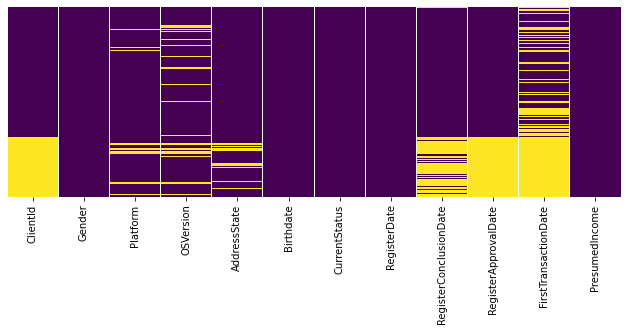

In [6]:
#setando o tamanho do gráfico
plt.figure(figsize=(11, 3.5))

#plotando o heatmap para mapear valores nulos
sns.heatmap(client.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [7]:
#contagem de valores nulos e ordenação
client.isna().sum().sort_values(ascending=False)

FirstTransactionDate      30310
ClientId                  18089
RegisterApprovalDate      18089
RegisterConclusionDate    13948
OSVersion                  6781
AddressState               3779
Platform                   3511
Birthdate                    30
Gender                        0
CurrentStatus                 0
RegisterDate                  0
PresumedIncome                0
dtype: int64

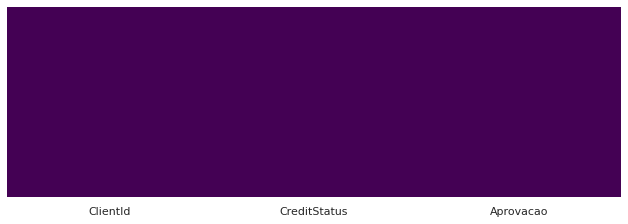

In [50]:
#setando o tamanho do gráfico
plt.figure(figsize=(11, 3.5))

#plotando o heatmap para mapear valores nulos
sns.heatmap(credit_status.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [9]:
#contagem de valores nulos e ordenação
credit_status.isna().sum().sort_values(ascending=False)

ClientId        0
CreditStatus    0
dtype: int64

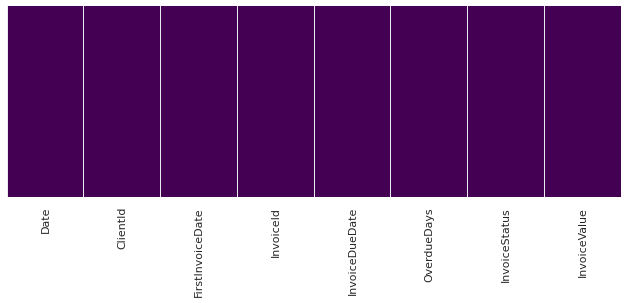

In [51]:
#setando o tamanho do gráfico
plt.figure(figsize=(11, 3.5))

#plotando o heatmap para mapear valores nulos
sns.heatmap(invoice_status.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [11]:
#contagem de valores nulos e ordenação
invoice_status.isna().sum().sort_values(ascending=False)

Date                0
ClientId            0
FirstInvoiceDate    0
InvoiceId           0
InvoiceDueDate      0
OverdueDays         0
InvoiceStatus       0
InvoiceValue        0
dtype: int64

*   **1.1: Qual a taxa de aprovação dos clientes? (i.e., qual o percentual de clientes aprovados)**	
*   **1.2: Quais características dos clientes apresentam maior correlação com a resposta de aprovação do motor de crédito?** 

In [12]:
#mostrar os valores distintos pra poder classificar mais um de uma categoria em "Aprovado"
print(credit_status['CreditStatus'].unique())

['Ativo' 'Reprovado' 'Bloqueado' 'Aprovado']


In [13]:
#contagem de clientes em cada categoria 'CreditStatus'
credit_status.groupby('CreditStatus')['ClientId'].count()

CreditStatus
Aprovado       203
Ativo        16749
Bloqueado     2189
Reprovado    15622
Name: ClientId, dtype: int64

In [14]:
# agrupar a categoria "Ativo" dentro de "Aprovado" para facilitar o cálculo
conditions = [
    (credit_status['CreditStatus'] == 'Ativo'),
    (credit_status['CreditStatus'] == 'Reprovado'),
    (credit_status['CreditStatus'] == 'Bloqueado'),
    (credit_status['CreditStatus'] == 'Aprovado')]

#valores ordenados que serão substítuidos
values = ['Aprovado', 'Reprovado', 'Bloqueado', 'Aprovado']

In [15]:
#aplicar a função pra susbtituir "Ativo" em "Aprovado"
credit_status['Aprovacao'] = np.select(conditions, values)

#contagem de clientes em cada nova categoria "CreditStatus"
approve = credit_status.groupby('Aprovacao')['ClientId'].count()

#exibir o resultado
print(approve)

Aprovacao
Aprovado     16952
Bloqueado     2189
Reprovado    15622
Name: ClientId, dtype: int64


In [16]:
#cálculo da taxa de aprovação na visão geral
taxa_aprovacao = approve[0] / approve.sum()
print((np.round(taxa_aprovacao, 3) * 100), "%")

48.8 %


**1.1: Taxa de aprovação dos clientes = 48,8%**


---
---

In [83]:
#unindo os datasets credit e client
motor_corr = pd.merge(credit_status, client, how='left', on='ClientId')

#selecionando apenas as variáveis mais relevantes para fazer correlação
motor_corr_clean = motor_corr[['CreditStatus', 'Aprovacao', 'Gender', 'Platform', 'OSVersion', 'AddressState', 'Birthdate', 'CurrentStatus', 'PresumedIncome', 'RegisterApprovalDate']]

#visualizando as primeiras linhas
motor_corr_clean.head(3)

#construindo a variável idade
motor_corr_clean['idade'] = motor_corr_clean.RegisterApprovalDate - motor_corr_clean.Birthdate

#convertendo a variável idade para númerico
motor_corr_clean['idade'] = (motor_corr_clean['idade'].dt.days / 365).astype('int')

#mostrando as primeiras linhas
motor_corr_clean.head(3)

,CreditStatus,Aprovacao,Gender,Platform,OSVersion,AddressState,Birthdate,CurrentStatus,PresumedIncome,RegisterApprovalDate,idade
0,Ativo,Aprovado,Male,Android,7.0,PR,1990-10-23,Aprovado,1391.24,2018-10-16,28
1,Ativo,Aprovado,Female,Android,NaN,SC,1990-08-22,Aprovado,1227.42,2018-11-10,28
2,Ativo,Aprovado,Male,Android,8.0.0,SP,1984-01-09,Aprovado,4076.58,2018-12-16,34


In [18]:
# agrupar a categoria "Ativo" dentro de "Aprovado" para facilitar o cálculo
fx_idade_1 = motor_corr_clean.loc[(motor_corr_clean['idade'] <= 18)]
fx_idade_1['fx_idade'] = '0-18'

fx_idade_2 = motor_corr_clean.loc[(motor_corr_clean['idade'] > 18) & (motor_corr_clean['idade'] <= 26)]
fx_idade_2['fx_idade'] = '19-26'

fx_idade_3 = motor_corr_clean.loc[(motor_corr_clean['idade'] > 26) & (motor_corr_clean['idade'] <= 34)]
fx_idade_3['fx_idade'] = '27-34'

fx_idade_4 = motor_corr_clean.loc[(motor_corr_clean['idade'] > 34) & (motor_corr_clean['idade'] <= 42)]
fx_idade_4['fx_idade'] = '35-42'

fx_idade_5 = motor_corr_clean.loc[(motor_corr_clean['idade'] > 42) & (motor_corr_clean['idade'] <= 50)]
fx_idade_5['fx_idade'] = '43-50'

fx_idade_6 = motor_corr_clean.loc[(motor_corr_clean['idade'] > 50) & (motor_corr_clean['idade'] <= 58)]
fx_idade_6['fx_idade'] = '51-58'

fx_idade_7 = motor_corr_clean.loc[(motor_corr_clean['idade'] > 58)]
fx_idade_7['fx_idade'] = 'maior que 58'

novo_df = pd.concat([fx_idade_1, fx_idade_2, fx_idade_3, fx_idade_4, fx_idade_5, fx_idade_6, fx_idade_7])

#plt.figure(figsize=(13, 6))
#novo_df.groupby('fx_idade')['PresumedIncome'].mean().plot(kind='bar')

In [19]:
# agrupar a categoria "Ativo" dentro de "Aprovado" para facilitar o cálculo
conditions_1 = [
    (novo_df['CreditStatus'] == 'Ativo'),
    (novo_df['CreditStatus'] == 'Reprovado'),
    (novo_df['CreditStatus'] == 'Bloqueado'),
    (novo_df['CreditStatus'] == 'Aprovado')]

#valores ordenados que serão substítuidos
#values = [1, 2, 3, 4]
values_v2 = [1, 0, 0, 1]

#aplicar a função pra susbtituir "Ativo" em "Aprovado"
#novo_df['CreditStatus_flg'] = np.select(conditions_1, values)
novo_df['CreditStatus_flg'] = np.select(conditions_1, values_v2)

In [20]:
# agrupar a categoria "Ativo" dentro de "Aprovado" para facilitar o cálculo
conditions_2 = [
    (novo_df['fx_idade'] == '0-18'),
    (novo_df['fx_idade'] == '19-26'),
    (novo_df['fx_idade'] == '27-34'),
    (novo_df['fx_idade'] == '35-42'),
    (novo_df['fx_idade'] == '43-50'),
    (novo_df['fx_idade'] == '51-58'),
    (novo_df['fx_idade'] == 'maior que 58')]

#valores ordenados que serão substítuidos
values = [1, 2, 3, 4, 5, 6, 7]

#aplicar a função pra susbtituir "Ativo" em "Aprovado"
novo_df['fx_idade_flg'] = np.select(conditions_2, values)

novo_df[['fx_idade_flg', 'CreditStatus_flg']].corr()

,fx_idade_flg,CreditStatus_flg
fx_idade_flg,1.00000,0.10794
CreditStatus_flg,0.10794,1.00000


In [21]:
novo_df['Gender'].unique()

array(['Female', 'Male', 'Unknown'], dtype=object)

In [22]:
conditions_3 = [
    (novo_df['Gender'] == 'Male'),
    (novo_df['Gender'] == 'Female'),
    (novo_df['Gender'] == 'Unknown')]

#valores ordenados que serão substítuidos
values = [1, 2, 3]

#aplicar a função pra susbtituir "Ativo" em "Aprovado"
novo_df['Gender_flg'] = np.select(conditions_3, values)

novo_df[['Gender_flg', 'CreditStatus_flg']].corr()

,Gender_flg,CreditStatus_flg
Gender_flg,1.000000,-0.030154
CreditStatus_flg,-0.030154,1.000000


In [23]:
novo_df['Platform'].unique()

array(['iPhone+OS', 'Android', nan], dtype=object)

In [24]:
conditions_4 = [
    (novo_df['Platform'] == 'iPhone+OS'),
    (novo_df['Platform'] == 'Android'),
    (novo_df['Platform'] == '')]

#valores ordenados que serão substítuidos
values = [1, 2, 3]

#aplicar a função pra susbtituir "Ativo" em "Aprovado"
novo_df['Platform_flg'] = np.select(conditions_4, values)

novo_df[['Platform_flg', 'CreditStatus_flg']].corr()

,Platform_flg,CreditStatus_flg
Platform_flg,1.000000,-0.052547
CreditStatus_flg,-0.052547,1.000000


In [25]:
novo_df['OSVersion'].unique()

array(['10.3.3', '7.0', '11.3.1', '6.0.1', '12.2', '11.4', 9, nan,
       '7.1.1', '8.1.0', '8.0.0', '12.1', '13.1.3', '12.4', '5.1.1',
       '13.1.2', '12.4.1', '11.1.2', '12.4.2', '6.0', '12.1.4', '10.2.1',
       '5.0.2', '13.3', '7.1.2', '13.0', '10.0', '12.3.1', '5.1',
       '12.1.2', '12.4.3', '11.4.1', '11.2.6', '4.4.2', '11.0', '10.1.1',
       '13.2.3', '11.0.3', '12.1.1', '9.3.5', '10.3.1', '12.3.2', '5.0.1',
       '1.0.7.2', '13.2', '4.4.4', '5.0', '11.2.5', '12.0.1', '12.0',
       '4.2.2', '11.3', '10.3.2', '10.0.2', '11.2.1', '12.3', '9.3.2',
       '4.3', '12.1.3', '11.1', '4.1.2', '12.4.4', '9.3.6', '10.3.4',
       '10.2', '11.1.1', '1.0.8.2', '13.2.2', '11.0.1', '11.2.2', '10.1',
       '1.0.8.1', '11.0.2', '13.1.1', '10.0.1', '13.1', '9.2.1', '9.3.4',
       '4.4.3', '1.0.8', '11.2', '9.3', '9.0', '9.3.3', '10.3', '9.2',
       '9.3.1', '7.1', 10, '8.1.0+++xXx_NoLimits_3.3', '6.1', '8.1',
       '8.0'], dtype=object)

In [26]:
conditions_6 = [
    (novo_df['OSVersion'] == '10.3.3'),
    (novo_df['OSVersion'] == '7.0'),
    (novo_df['OSVersion'] == '11.3.1'),
    (novo_df['OSVersion'] == '6.0.1'),
    (novo_df['OSVersion'] == '12.2'),
    (novo_df['OSVersion'] == '11.4'),
    (novo_df['OSVersion'] == ''),
    (novo_df['OSVersion'] == '7.1.1'),
    (novo_df['OSVersion'] == '8.1.0'),
    (novo_df['OSVersion'] == '8.0.0'),
    (novo_df['OSVersion'] == '12.1'),
    (novo_df['OSVersion'] == '13.1.3'),
    (novo_df['OSVersion'] == '12.4'),
    (novo_df['OSVersion'] == '5.1.1'),
    (novo_df['OSVersion'] == '13.1.2'),
    (novo_df['OSVersion'] == '12.4.1'),
    (novo_df['OSVersion'] == '11.1.2'),
    (novo_df['OSVersion'] == '12.4.2'),
    (novo_df['OSVersion'] == '6.0'),
    (novo_df['OSVersion'] == '12.1.4'),
    (novo_df['OSVersion'] == '10.2.1'),
    (novo_df['OSVersion'] == '5.0.2'),
    (novo_df['OSVersion'] == '13.3'),
    (novo_df['OSVersion'] == '7.1.2'),
    (novo_df['OSVersion'] == '13.0'),
    (novo_df['OSVersion'] == '10.0'),
    (novo_df['OSVersion'] == '12.3.1'),
    (novo_df['OSVersion'] == '5.1'),
    (novo_df['OSVersion'] == '12.1.2'),
    (novo_df['OSVersion'] == '12.4.3'),
    (novo_df['OSVersion'] == '11.4.1'),
    (novo_df['OSVersion'] == '11.2.6'),
    (novo_df['OSVersion'] == '4.4.2'),
    (novo_df['OSVersion'] == '11.0'),
    (novo_df['OSVersion'] == '10.1.1'),
    (novo_df['OSVersion'] == '13.2.3'),
    (novo_df['OSVersion'] == '11.0.3'),
    (novo_df['OSVersion'] == '12.1.1'),
    (novo_df['OSVersion'] == '9.3.5'),
    (novo_df['OSVersion'] == '10.3.1'),
    (novo_df['OSVersion'] == '12.3.2'),
    (novo_df['OSVersion'] == '5.0.1'),
    (novo_df['OSVersion'] == '1.0.7.2'),
    (novo_df['OSVersion'] == '13.2'),
    (novo_df['OSVersion'] == '4.4.4'),
    (novo_df['OSVersion'] == '5.0'),
    (novo_df['OSVersion'] == '11.2.5'),
    (novo_df['OSVersion'] == '12.0.1'),
    (novo_df['OSVersion'] == '12.0'),
    (novo_df['OSVersion'] == '4.2.2'),
    (novo_df['OSVersion'] == '11.3'),
    (novo_df['OSVersion'] == '10.3.2'),
    (novo_df['OSVersion'] == '10.0.2'),
    (novo_df['OSVersion'] == '11.2.1'),
    (novo_df['OSVersion'] == '12.3'),
    (novo_df['OSVersion'] == '9.3.2'),
    (novo_df['OSVersion'] == '4.3'),
    (novo_df['OSVersion'] == '12.1.3'),
    (novo_df['OSVersion'] == '11.1'),
    (novo_df['OSVersion'] == '4.1.2'),
    (novo_df['OSVersion'] == '12.4.4'),
    (novo_df['OSVersion'] == '9.3.6'),
    (novo_df['OSVersion'] == '10.3.4'),
    (novo_df['OSVersion'] == '10.2'),
    (novo_df['OSVersion'] == '11.1.1'),
    (novo_df['OSVersion'] == '1.0.8.2'),
    (novo_df['OSVersion'] == '13.2.2'),
    (novo_df['OSVersion'] == '11.0.1'),
    (novo_df['OSVersion'] == '11.2.2'),
    (novo_df['OSVersion'] == '10.1'),
    (novo_df['OSVersion'] == '1.0.8.1'),
    (novo_df['OSVersion'] == '11.0.2'),
    (novo_df['OSVersion'] == '13.1.1'),
    (novo_df['OSVersion'] == '10.0.1'),
    (novo_df['OSVersion'] == '13.1'),
    (novo_df['OSVersion'] == '9.2.1'),
    (novo_df['OSVersion'] == '9.3.4'),
    (novo_df['OSVersion'] == '4.4.3'),
    (novo_df['OSVersion'] == '1.0.8'),
    (novo_df['OSVersion'] == '11.2'),
    (novo_df['OSVersion'] == '9.3'),
    (novo_df['OSVersion'] == '9.0'),
    (novo_df['OSVersion'] == '9.3.3'),
    (novo_df['OSVersion'] == '10.3'),
    (novo_df['OSVersion'] == '9.2'),
    (novo_df['OSVersion'] == '9.3.1'),
    (novo_df['OSVersion'] == '7.1'),
    (novo_df['OSVersion'] == '10'),
    (novo_df['OSVersion'] == '8.1.0+++xXx_NoLimits_3.3'),
    (novo_df['OSVersion'] == '6.1'),
    (novo_df['OSVersion'] == '8.1'),
    (novo_df['OSVersion'] == '8.0')]

values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]

novo_df['OSVersion_flg'] = np.select(conditions_6, values)


**Correlação entre as variáveis de clientes e a resposta do motor**

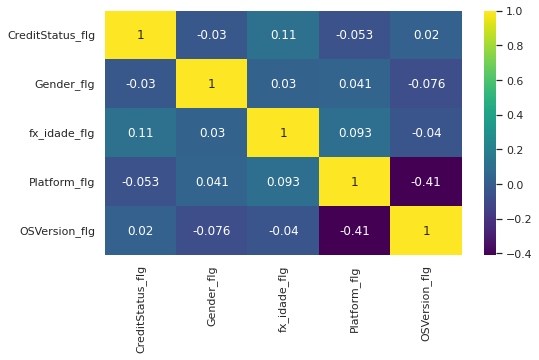

In [76]:
plt.figure(figsize=(8, 4.5))
sns.heatmap(novo_df[['CreditStatus_flg', 'Gender_flg', 'fx_idade_flg', 'Platform_flg', 'OSVersion_flg']].corr(), annot=True, cmap='viridis')

In [28]:
#criando uma cópia do dataset invoice
inad_geral = invoice_status.copy()

#excluindo faturas nulas que não compõem o indicador
inad_geral_v1 = inad_geral.loc[(inad_geral['InvoiceValue'] != 0)]

#aplicando a marcação de over30
inad_geral_v1['Over'] = np.where(inad_geral_v1['OverdueDays'] >= 30, 'Sim', 'Não')

inad_geral_v1 = inad_geral_v1.groupby('Over')['ClientId'].count()
over_30_geral = inad_geral_v1[1] / inad_geral_v1.sum()

print((np.round(over_30_geral, 3) * 100), "%")
print('\n')
print(inad_geral_v1)

10.9 %


Over
Não    93931
Sim    11494
Name: ClientId, dtype: int64


**2.1: Over 30 mob3 - visão geral = 10,9%**


---
---

**Over 30 - Safra Janeiro/19**

In [29]:
jan = invoice_status.loc[(invoice_status['FirstInvoiceDate'] >= '2019-01-01') & (invoice_status['FirstInvoiceDate'] <= '2019-01-31') 
                            & (invoice_status['InvoiceDueDate'] >= '2019-04-01') & (invoice_status['InvoiceDueDate'] <= '2019-04-30') & (invoice_status['InvoiceValue'] != 0)]

inad_jan = pd.DataFrame()
inad_jan['Over'] = np.where(jan['OverdueDays'] >= 30, 'Sim', 'Não')

inad_jan = inad_jan.groupby('Over')['Over'].count()
over_30_jan = inad_jan[1] / inad_jan.sum()

print((np.round(over_30_jan, 3) * 100), "%")
print('\n')
inad_jan

10.7 %




Over
Não    646
Sim     77
Name: Over, dtype: int64

**Over 30 - Safra Fevereiro/19**

In [30]:
fev = invoice_status.loc[(invoice_status['FirstInvoiceDate'] >= '2019-02-01') & (invoice_status['FirstInvoiceDate'] <= '2019-02-28') 
                            & (invoice_status['InvoiceDueDate'] >= '2019-05-01') & (invoice_status['InvoiceDueDate'] <= '2019-05-31') & (invoice_status['InvoiceValue'] != 0)]

inad_fev = pd.DataFrame()
inad_fev['Over'] = np.where(fev['OverdueDays'] >= 30, 'Sim', 'Não')

inad_fev = inad_fev.groupby('Over')['Over'].count()
over_30_fev = inad_fev[1] / inad_fev.sum()

print((np.round(over_30_fev, 3) * 100), "%")
print('\n')
inad_fev

11.0 %




Over
Não    835
Sim    103
Name: Over, dtype: int64

**Over 30 - Safra Março/19**

In [31]:
mar = invoice_status.loc[(invoice_status['FirstInvoiceDate'] >= '2019-03-01') & (invoice_status['FirstInvoiceDate'] <= '2019-03-31') 
                            & (invoice_status['InvoiceDueDate'] >= '2019-06-01') & (invoice_status['InvoiceDueDate'] <= '2019-06-30') & (invoice_status['InvoiceValue'] != 0)]

inad_mar = pd.DataFrame()
inad_mar['Over'] = np.where(mar['OverdueDays'] >= 30, 'Sim', 'Não')

inad_mar = inad_mar.groupby('Over')['Over'].count()
over_30_mar = inad_mar[1] / inad_mar.sum()

print((np.round(over_30_mar, 3) * 100), "%")
print('\n')
inad_mar

10.100000000000001 %




Over
Não    773
Sim     87
Name: Over, dtype: int64

**Over 30 - Safra Abril/19**

In [32]:
abr = invoice_status.loc[(invoice_status['FirstInvoiceDate'] >= '2019-04-01') & (invoice_status['FirstInvoiceDate'] <= '2019-04-30') 
                            & (invoice_status['InvoiceDueDate'] >= '2019-07-01') & (invoice_status['InvoiceDueDate'] <= '2019-07-31') & (invoice_status['InvoiceValue'] != 0)]

inad_abr = pd.DataFrame()
inad_abr['Over'] = np.where(abr['OverdueDays'] >= 30, 'Sim', 'Não')

inad_abr = inad_abr.groupby('Over')['Over'].count()
over_30_abr = inad_abr[1] / inad_abr.sum()

print((np.round(over_30_abr, 3) * 100), "%")
print('\n')
inad_abr

11.200000000000001 %




Over
Não    1035
Sim     130
Name: Over, dtype: int64

**Over 30 - Safra Maio/19**

In [33]:
mai = invoice_status.loc[(invoice_status['FirstInvoiceDate'] >= '2019-05-01') & (invoice_status['FirstInvoiceDate'] <= '2019-05-31') 
                            & (invoice_status['InvoiceDueDate'] >= '2019-08-01') & (invoice_status['InvoiceDueDate'] <= '2019-08-31') & (invoice_status['InvoiceValue'] != 0)]

inad_mai = pd.DataFrame()
inad_mai['Over'] = np.where(mai['OverdueDays'] >= 30, 'Sim', 'Não')

inad_mai = inad_mai.groupby('Over')['Over'].count()
over_30_mai = inad_mai[1] / inad_mai.sum()

print((np.round(over_30_mai, 3) * 100), "%")
print('\n')
inad_mai

25.1 %




Over
Não    1515
Sim     507
Name: Over, dtype: int64

**Over 30 - Safra Junho/19**

In [34]:
jun = invoice_status.loc[(invoice_status['FirstInvoiceDate'] >= '2019-06-01') & (invoice_status['FirstInvoiceDate'] <= '2019-06-30') 
                            & (invoice_status['InvoiceDueDate'] >= '2019-09-01') & (invoice_status['InvoiceDueDate'] <= '2019-09-30') & (invoice_status['InvoiceValue'] != 0)]

inad_jun = pd.DataFrame()
inad_jun['Over'] = np.where(jun['OverdueDays'] >= 30, 'Sim', 'Não')

inad_jun = inad_jun.groupby('Over')['Over'].count()
over_30_jun = inad_jun[1] / inad_jun.sum()

print((np.round(over_30_jun, 3) * 100), "%")
print('\n')
inad_jun

24.4 %




Over
Não    1495
Sim     482
Name: Over, dtype: int64

**Over 30 - Safra Julho/19**

In [35]:
jul = invoice_status.loc[(invoice_status['FirstInvoiceDate'] >= '2019-07-01') & (invoice_status['FirstInvoiceDate'] <= '2019-07-31') 
                            & (invoice_status['InvoiceDueDate'] >= '2019-10-01') & (invoice_status['InvoiceDueDate'] <= '2019-10-31') & (invoice_status['InvoiceValue'] != 0)]

inad_jul = pd.DataFrame()
inad_jul['Over'] = np.where(jul['OverdueDays'] >= 30, 'Sim', 'Não')

inad_jul = inad_jul.groupby('Over')['Over'].count()
over_30_jul = inad_jul[1] / inad_jul.sum()

print((np.round(over_30_jul, 3) * 100), "%")
print('\n')
inad_jul

11.3 %




Over
Não    1171
Sim     149
Name: Over, dtype: int64

**Over 30 - Safra Agosto/19**

In [36]:
ago = invoice_status.loc[(invoice_status['FirstInvoiceDate'] >= '2019-08-01') & (invoice_status['FirstInvoiceDate'] <= '2019-08-31') 
                            & (invoice_status['InvoiceDueDate'] >= '2019-11-01') & (invoice_status['InvoiceDueDate'] <= '2019-11-30') & (invoice_status['InvoiceValue'] != 0)]

inad_ago = pd.DataFrame()
inad_ago['Over'] = np.where(ago['OverdueDays'] >= 30, 'Sim', 'Não')

inad_ago = inad_ago.groupby('Over')['Over'].count()
over_30_ago = inad_ago[1] / inad_ago.sum()

print((np.round(over_30_ago, 3) * 100), "%")
print('\n')
inad_ago

8.1 %




Over
Não    1235
Sim     109
Name: Over, dtype: int64

**Over 30 - Safra Setembro/19**

In [37]:
sep = invoice_status.loc[(invoice_status['FirstInvoiceDate'] >= '2019-09-01') & (invoice_status['FirstInvoiceDate'] <= '2019-09-30') 
                            & (invoice_status['InvoiceDueDate'] >= '2019-12-01') & (invoice_status['InvoiceDueDate'] <= '2019-12-31') & (invoice_status['InvoiceValue'] != 0)]

inad_set = pd.DataFrame()
inad_set['Over'] = np.where(sep['OverdueDays'] >= 30, 'Sim', 'Não')

inad_set = inad_set.groupby('Over')['Over'].count()
over_30_set = inad_set[1] / inad_set.sum()

print((np.round(over_30_set, 3) * 100), "%")
print('\n')
inad_set

10.0 %




Over
Não    1543
Sim     171
Name: Over, dtype: int64

**Over 30 - Safra Outubro/19**

In [38]:
out = invoice_status.loc[(invoice_status['FirstInvoiceDate'] >= '2019-10-01') & (invoice_status['FirstInvoiceDate'] <= '2019-10-31') 
                            & (invoice_status['InvoiceDueDate'] >= '2020-01-01') & (invoice_status['InvoiceDueDate'] <= '2020-01-31') & (invoice_status['InvoiceValue'] != 0)]

inad_out = pd.DataFrame()
inad_out['Over'] = np.where(out['OverdueDays'] >= 30, 'Sim', 'Não')

inad_out = inad_out.groupby('Over')['Over'].count()
over_30_out = inad_out[1] / inad_out.sum()

print((np.round(over_30_out, 3) * 100), "%")
print('\n')
inad_out

10.9 %




Over
Não    327
Sim     40
Name: Over, dtype: int64

**Gráfico: Over 30 mob3 Por Safra**

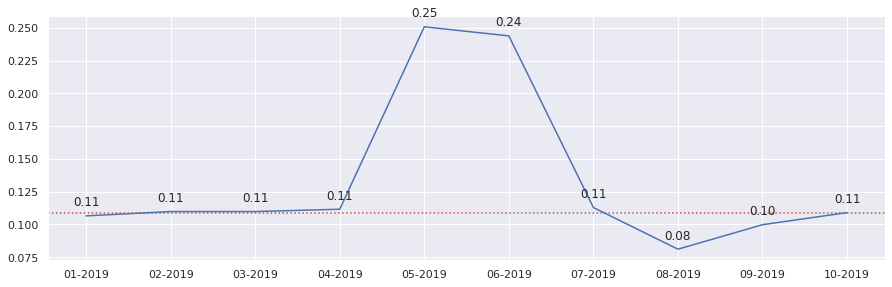

In [39]:
#construção da tabela de forma ordenada
x = ['01-2019', '02-2019', '03-2019', '04-2019', '05-2019', '06-2019', '07-2019', '08-2019', '09-2019', '10-2019']
y = [over_30_jan, over_30_fev, over_30_fev, over_30_abr, over_30_mai, over_30_jun, over_30_jul, over_30_ago, over_30_set, over_30_out]

#ajuste do estilo do gráfico
sns.set_theme(style="darkgrid")

#configuração do tamanho do gráfico
plt.figure(figsize=(15, 4.5))

#construção da linha over_30 mob3 fixa (10% é a visão geral do indicador)
plt.axhline(y=over_30_geral, color='r', linestyle='dotted')

#plotando o lineplot
sns.lineplot(x, y)

#função para exibir os rótulos
for x,y in zip(x,y):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

#plotar o gráfico
plt.show()

**2.1: Over 30 mob3 - visão safras**


*   Jan/19 = 10,7%
*   Fev/19 = 11,0%
*   Mar/19 = 10,1%
*   Abr/19 = 11,2%
*   Mai/19 = 25,1%
*   Jun/19 = 24,4%
*   Jul/19 = 11,3%
*   Ago/19 = 8,1%
*   Set/19 = 10,0%
*   Out/19 = 10,9%




**3.1: A percepção do time de cartão não está correta.** <br><br>
**3.1: A percepção de tendência de aumento da inadimplência para as safras do 2º semestre de 2019 se deve ao fato de que em agosto observamos a menor inadimplância histórica. Nos meses seguintes a inadimplência volta a se aproximar da média histórica e isso faz com que exista uma "tendência mascarada" se analisarmos um curto período.**

In [40]:
#cópia do dataset principal
copy_client = client.copy()

#join entre os datasets: invoice e client
data_modelo = pd.merge(invoice_status, copy_client, how='left', on='ClientId')

#construção da variával safra para facilitar a análise
data_modelo['Safra'] = data_modelo['FirstInvoiceDate'].dt.strftime('%m-%Y')

# exibição das primeiras linhas para validação
data_modelo.head()
################################################################################################






#construindo a variável idade
data_modelo['idade'] = data_modelo.RegisterApprovalDate - data_modelo.Birthdate

#convertendo a variável idade para númerico
data_modelo['idade'] = (data_modelo['idade'].dt.days / 365)


# agrupar a categoria "Ativo" dentro de "Aprovado" para facilitar o cálculo
fx_idade_1 = data_modelo.loc[(data_modelo['idade'] <= 18)]
fx_idade_1['fx_idade'] = '0-18'

fx_idade_2 = data_modelo.loc[(data_modelo['idade'] > 18) & (data_modelo['idade'] <= 26)]
fx_idade_2['fx_idade'] = '19-26'

fx_idade_3 = data_modelo.loc[(data_modelo['idade'] > 26) & (data_modelo['idade'] <= 34)]
fx_idade_3['fx_idade'] = '27-34'

fx_idade_4 = data_modelo.loc[(data_modelo['idade'] > 34) & (data_modelo['idade'] <= 42)]
fx_idade_4['fx_idade'] = '35-42'

fx_idade_5 = data_modelo.loc[(data_modelo['idade'] > 42) & (data_modelo['idade'] <= 50)]
fx_idade_5['fx_idade'] = '43-50'

fx_idade_6 = data_modelo.loc[(data_modelo['idade'] > 50) & (data_modelo['idade'] <= 58)]
fx_idade_6['fx_idade'] = '51-58'

fx_idade_7 = data_modelo.loc[(data_modelo['idade'] > 58)]
fx_idade_7['fx_idade'] = 'maior que 58'

data_modelo = pd.concat([fx_idade_1, fx_idade_2, fx_idade_3, fx_idade_4, fx_idade_5, fx_idade_6, fx_idade_7])







#construção da flag idade
# agrupar a categoria "Ativo" dentro de "Aprovado" para facilitar o cálculo
cond_model_1 = [
    (data_modelo['fx_idade'] == '0-18'),
    (data_modelo['fx_idade'] == '19-26'),
    (data_modelo['fx_idade'] == '27-34'),
    (data_modelo['fx_idade'] == '35-42'),
    (data_modelo['fx_idade'] == '43-50'),
    (data_modelo['fx_idade'] == '51-58'),
    (data_modelo['fx_idade'] == 'maior que 58')]

#valores ordenados que serão substítuidos
values = [1, 2, 3, 4, 5, 6, 7]

#aplicar a função pra susbtituir "fx_idade" em "fx_idade_flg"
data_modelo['fx_idade_flg'] = np.select(cond_model_1, values)







#construção da flg Platform
cond_model_2 = [
    (data_modelo['OSVersion'] == '10.3.3'),
    (data_modelo['OSVersion'] == '7.0'),
    (data_modelo['OSVersion'] == '11.3.1'),
    (data_modelo['OSVersion'] == '6.0.1'),
    (data_modelo['OSVersion'] == '12.2'),
    (data_modelo['OSVersion'] == '11.4'),
    (data_modelo['OSVersion'] == ''),
    (data_modelo['OSVersion'] == '7.1.1'),
    (data_modelo['OSVersion'] == '8.1.0'),
    (data_modelo['OSVersion'] == '8.0.0'),
    (data_modelo['OSVersion'] == '12.1'),
    (data_modelo['OSVersion'] == '13.1.3'),
    (data_modelo['OSVersion'] == '12.4'),
    (data_modelo['OSVersion'] == '5.1.1'),
    (data_modelo['OSVersion'] == '13.1.2'),
    (data_modelo['OSVersion'] == '12.4.1'),
    (data_modelo['OSVersion'] == '11.1.2'),
    (data_modelo['OSVersion'] == '12.4.2'),
    (data_modelo['OSVersion'] == '6.0'),
    (data_modelo['OSVersion'] == '12.1.4'),
    (data_modelo['OSVersion'] == '10.2.1'),
    (data_modelo['OSVersion'] == '5.0.2'),
    (data_modelo['OSVersion'] == '13.3'),
    (data_modelo['OSVersion'] == '7.1.2'),
    (data_modelo['OSVersion'] == '13.0'),
    (data_modelo['OSVersion'] == '10.0'),
    (data_modelo['OSVersion'] == '12.3.1'),
    (data_modelo['OSVersion'] == '5.1'),
    (data_modelo['OSVersion'] == '12.1.2'),
    (data_modelo['OSVersion'] == '12.4.3'),
    (data_modelo['OSVersion'] == '11.4.1'),
    (data_modelo['OSVersion'] == '11.2.6'),
    (data_modelo['OSVersion'] == '4.4.2'),
    (data_modelo['OSVersion'] == '11.0'),
    (data_modelo['OSVersion'] == '10.1.1'),
    (data_modelo['OSVersion'] == '13.2.3'),
    (data_modelo['OSVersion'] == '11.0.3'),
    (data_modelo['OSVersion'] == '12.1.1'),
    (data_modelo['OSVersion'] == '9.3.5'),
    (data_modelo['OSVersion'] == '10.3.1'),
    (data_modelo['OSVersion'] == '12.3.2'),
    (data_modelo['OSVersion'] == '5.0.1'),
    (data_modelo['OSVersion'] == '1.0.7.2'),
    (data_modelo['OSVersion'] == '13.2'),
    (data_modelo['OSVersion'] == '4.4.4'),
    (data_modelo['OSVersion'] == '5.0'),
    (data_modelo['OSVersion'] == '11.2.5'),
    (data_modelo['OSVersion'] == '12.0.1'),
    (data_modelo['OSVersion'] == '12.0'),
    (data_modelo['OSVersion'] == '4.2.2'),
    (data_modelo['OSVersion'] == '11.3'),
    (data_modelo['OSVersion'] == '10.3.2'),
    (data_modelo['OSVersion'] == '10.0.2'),
    (data_modelo['OSVersion'] == '11.2.1'),
    (data_modelo['OSVersion'] == '12.3'),
    (data_modelo['OSVersion'] == '9.3.2'),
    (data_modelo['OSVersion'] == '4.3'),
    (data_modelo['OSVersion'] == '12.1.3'),
    (data_modelo['OSVersion'] == '11.1'),
    (data_modelo['OSVersion'] == '4.1.2'),
    (data_modelo['OSVersion'] == '12.4.4'),
    (data_modelo['OSVersion'] == '9.3.6'),
    (data_modelo['OSVersion'] == '10.3.4'),
    (data_modelo['OSVersion'] == '10.2'),
    (data_modelo['OSVersion'] == '11.1.1'),
    (data_modelo['OSVersion'] == '1.0.8.2'),
    (data_modelo['OSVersion'] == '13.2.2'),
    (data_modelo['OSVersion'] == '11.0.1'),
    (data_modelo['OSVersion'] == '11.2.2'),
    (data_modelo['OSVersion'] == '10.1'),
    (data_modelo['OSVersion'] == '1.0.8.1'),
    (data_modelo['OSVersion'] == '11.0.2'),
    (data_modelo['OSVersion'] == '13.1.1'),
    (data_modelo['OSVersion'] == '10.0.1'),
    (data_modelo['OSVersion'] == '13.1'),
    (data_modelo['OSVersion'] == '9.2.1'),
    (data_modelo['OSVersion'] == '9.3.4'),
    (data_modelo['OSVersion'] == '4.4.3'),
    (data_modelo['OSVersion'] == '1.0.8'),
    (data_modelo['OSVersion'] == '11.2'),
    (data_modelo['OSVersion'] == '9.3'),
    (data_modelo['OSVersion'] == '9.0'),
    (data_modelo['OSVersion'] == '9.3.3'),
    (data_modelo['OSVersion'] == '10.3'),
    (data_modelo['OSVersion'] == '9.2'),
    (data_modelo['OSVersion'] == '9.3.1'),
    (data_modelo['OSVersion'] == '7.1'),
    (data_modelo['OSVersion'] == '10'),
    (data_modelo['OSVersion'] == '8.1.0+++xXx_NoLimits_3.3'),
    (data_modelo['OSVersion'] == '6.1'),
    (data_modelo['OSVersion'] == '8.1'),
    (data_modelo['OSVersion'] == '8.0')]

values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]

data_modelo['OSVersion_flg'] = np.select(cond_model_2, values)








data_modelo['AddressState'].unique()
#construção da flg Estado

cond_model_3 = [
    (data_modelo['AddressState'] == 'SP'),
    (data_modelo['AddressState'] == 'AM'),
    (data_modelo['AddressState'] == 'GO'),
    (data_modelo['AddressState'] == 'MG'),
    (data_modelo['AddressState'] == 'ES'),
    (data_modelo['AddressState'] == 'CE'),
    (data_modelo['AddressState'] == 'DF'),
    (data_modelo['AddressState'] == 'MT'),
    (data_modelo['AddressState'] == 'PR'),
    (data_modelo['AddressState'] == 'BA'),
    (data_modelo['AddressState'] == 'AL'),
    (data_modelo['AddressState'] == 'PE'),
    (data_modelo['AddressState'] == 'RN'),
    (data_modelo['AddressState'] == 'RJ'),
    (data_modelo['AddressState'] == 'PB'),
    (data_modelo['AddressState'] == 'RS'),
    (data_modelo['AddressState'] == 'RO'),
    (data_modelo['AddressState'] == 'PA'),
    (data_modelo['AddressState'] == 'SC'),
    (data_modelo['AddressState'] == 'PI'),
    (data_modelo['AddressState'] == 'MS'),
    (data_modelo['AddressState'] == 'SE'),
    (data_modelo['AddressState'] == 'MA'),
    (data_modelo['AddressState'] == 'TO'),
    (data_modelo['AddressState'] == 'RR'),
    (data_modelo['AddressState'] == 'Piauí'),
    (data_modelo['AddressState'] == 'AP'),
    (data_modelo['AddressState'] == 'AC'),
    (data_modelo['AddressState'] == 'Bahia'),
    (data_modelo['AddressState'] == ''),
    (data_modelo['AddressState'] == 'Sc'),
    (data_modelo['AddressState'] == 'Ceará'),
    (data_modelo['AddressState'] == 'bahia'),
    (data_modelo['AddressState'] == 'Pe'),
    (data_modelo['AddressState'] == 'pr'),
    (data_modelo['AddressState'] == 'Se')]


values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 20, 27, 28, 10, 30, 19, 6, 10, 12, 9, 22]
data_modelo['AddressState_flg'] = np.select(cond_model_3, values)

data_modelo[['AddressState', 'AddressState_flg']].loc[(data_modelo['AddressState'] == 'nan')]








conditions_4 = [
    (data_modelo['Platform'] == 'iPhone+OS'),
    (data_modelo['Platform'] == 'Android'),
    (data_modelo['Platform'] == '')]

#valores ordenados que serão substítuidos
values = [1, 2, 3]

#aplicar a função pra susbtituir "Ativo" em "Aprovado"
data_modelo['Platform_flg'] = np.select(conditions_4, values)







conditions_5 = [
    (data_modelo['Gender'] == 'Male'),
    (data_modelo['Gender'] == 'Female'),
    (data_modelo['Gender'] == 'Unknown')]

#valores ordenados que serão substítuidos
values = [1, 2, 3]

#aplicar a função pra susbtituir "Ativo" em "Aprovado"
data_modelo['Gender_flg'] = np.select(conditions_5, values)










# agrupar a categoria "Ativo" dentro de "Aprovado" para facilitar o cálculo
cond_model_5 = [
    (data_modelo['InvoiceStatus'] == 'REGULAR'),
    (data_modelo['InvoiceStatus'] == 'INADIMPLENTE')]

values = [0, 1]
data_modelo['InvoiceStatus_flg'] = np.select(cond_model_5, values)

**Estudo das variáveis que podem impactar a indadimplência**

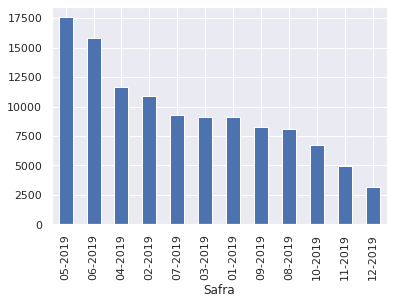

In [87]:
data_modelo.groupby('Safra')['ClientId'].count().sort_values(ascending=False).plot(kind='bar')

In [42]:
renda_maio = data_modelo.loc[(invoice_status['FirstInvoiceDate'] >= '2019-05-01') & (data_modelo['FirstInvoiceDate'] <= '2019-05-31') 
                            & (data_modelo['InvoiceDueDate'] >= '2019-08-01') & (data_modelo['InvoiceDueDate'] <= '2019-08-31') & (data_modelo['InvoiceValue'] != 0)]

renda_maio = renda_maio[['Safra', 'PresumedIncome', 'OSVersion_flg', 'AddressState_flg']]
renda_maio.describe()

,PresumedIncome,OSVersion_flg,AddressState_flg
count,2022.000000,2022.000000,2022.000000
mean,1574.026009,11.176558,8.327399
std,1830.838461,12.671466,6.356756
min,0.000000,0.000000,1.000000
25%,978.200000,2.000000,3.000000
50%,1187.845000,9.000000,7.000000
75%,1551.957500,14.000000,14.000000
max,41884.090000,84.000000,28.000000


In [43]:
renda_jun = data_modelo.loc[(invoice_status['FirstInvoiceDate'] >= '2019-06-01') & (data_modelo['FirstInvoiceDate'] <= '2019-06-30') 
                            & (data_modelo['InvoiceDueDate'] >= '2019-09-01') & (data_modelo['InvoiceDueDate'] <= '2019-09-30') & (data_modelo['InvoiceValue'] != 0)]

renda_jun = renda_jun[['Safra', 'PresumedIncome']]
renda_jun.describe()

,PresumedIncome
count,1977.000000
mean,1656.247699
std,1956.733030
min,0.000000
25%,991.780000
50%,1219.810000
75%,1625.990000
max,35878.330000


In [44]:
rend_ago = data_modelo.loc[(data_modelo['FirstInvoiceDate'] >= '2019-08-01') & (data_modelo['FirstInvoiceDate'] <= '2019-08-31') 
                            & (data_modelo['InvoiceDueDate'] >= '2019-11-01') & (data_modelo['InvoiceDueDate'] <= '2019-11-30') & (data_modelo['InvoiceValue'] != 0)]

rend_ago = rend_ago[['Safra', 'PresumedIncome']]
rend_ago.describe()

,PresumedIncome
count,1344.000000
mean,1745.564963
std,1416.858829
min,0.000000
25%,1068.320000
50%,1314.370000
75%,1959.987500
max,24024.370000


**Dataset preparado para ML**

In [110]:
data_modelo_v2 = data_modelo.loc[:, ['InvoiceStatus_flg', 'InvoiceValue', 'PresumedIncome', 'Platform_flg', 'AddressState_flg', 'fx_idade_flg', 'OSVersion_flg', 'Gender_flg']]
data_modelo_v2.head(3)

,InvoiceStatus_flg,InvoiceValue,PresumedIncome,Platform_flg,AddressState_flg,fx_idade_flg,OSVersion_flg,Gender_flg
6473,0,27.75,760.6,1,1,1,1,2
37283,1,569.96,760.6,1,1,1,1,2
105705,1,503.33,760.6,1,1,1,1,2


**Regressão Logística**

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

X = data_modelo_v2.iloc[:, [1, 2, 3, 4, 5, 6, 7]].values
y = data_modelo_v2.iloc[:, [0]].values

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

In [104]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('Acurácia no treino :', round(accuracy_score(y_train, y_train_pred), 5))

y_pred = model.predict(X_test)
print('Acurácia no teste :', round(accuracy_score(y_test, y_pred), 5))

Acurácia no treino : 0.90328
Acurácia no teste : 0.90116


**Avaliação do Modelo -  Matriz de Confusão**

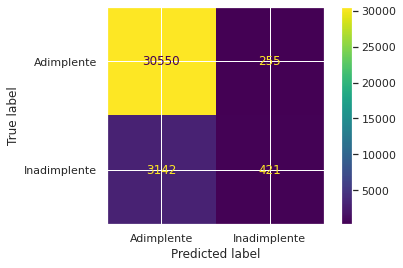

In [118]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Adimplente', 'Inadimplente'])
disp.plot()
plt.show()

**Árvore de Decisão**

In [119]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 15, random_state = 0)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
print('Acurácia no treino :', round(accuracy_score(y_train, y_train_pred), 5))

y_pred = tree.predict(X_test)
print('Acurácia no teste :', round(accuracy_score(y_test, y_pred), 5))

Acurácia no treino : 0.95205
Acurácia no teste : 0.90381


**Avaliação do Modelo -  Matriz de Confusão**

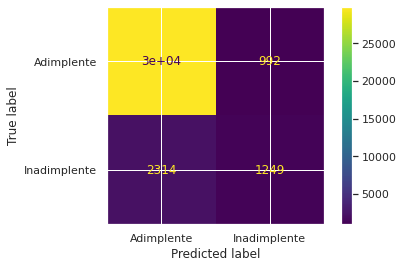

<Figure size 720x720 with 0 Axes>

In [124]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Adimplente', 'Inadimplente'])
disp.plot()
plt.figure(figsize=(10,10))
plt.show()

**Importância das variáveis para explicar a inadimplência**

In [49]:
import math

w0, w1, w2, w3, w4, w5, w6 = model.coef_[0]
w = [w0, w1, w2, w3, w4, w5, w6]

names = ['InvoiceValue', 'PresumedIncome', 'Platform_flg', 'AddressState_flg', 'fx_idade_flg', 'OSVersion_flg', 'Gender_flg']
df_importance = pd.DataFrame(names, columns=['variavel'])
df_importance['importancia'] = pow(math.e, np.array(w))

df_importance.sort_values(ascending=False, by='importancia')

,variavel,importancia
3,AddressState_flg,1.003534
0,InvoiceValue,1.002900
1,PresumedIncome,0.998325
5,OSVersion_flg,0.984068
4,fx_idade_flg,0.901200
6,Gender_flg,0.789643
2,Platform_flg,0.778996


**CONCLUSÕES**


1.   As variáveis: AddressState, InvoiValue e PresumedIncome possuem maior importância para o modelo de Machine Learning. Agora que validamos o modelo, podemos desenvolver estratégias de crédito personalizadas para cada cluster de clientes e o monitoramento da performance.

2.   O principal motivo do aumento da taxa de inadimplências em meses específicos foi ovolume de crédito concedido para um perfil de público jovem (idade até 30 anos). Esse público possui renda média significativamente abaixo de outros clusters.

3.  A construção e novas variáveis (feature engineering) se mostrou essencial para avançarmnos no estudo, uma vez que tanto variável idade e as variáveis categóricas (flags) não existiam nos datasets originais. 

4. A performance dos modelos de Machine Learning variaram significativamente. O processo de validação e escolha do modelo é sempre iterativo.

5. O over30 mob3 se manteve num patamar estavel durante o período analisado. Com excessão às safras de maio e junho, observamos o número em torno de 10% nas safras. 

6. Validamos analiticamente que a variável "Platform_flg" não tem grande importancia para o modelo de inadimplãncia. Isso contrapõe a hipótese (que parecia ser óbvia) em que usuários de iPhone teriam uma taxa de inadimplância menor e que existia uma correlação forte entre essa variável e a inadimplência.

**Obrigado!**

